In [1]:
import clustereval as ce
import pandas as pd 
import numpy as np 
import plotnine as pn
import glob
import re
import operator
import os
import pickle
import re
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari
os.chdir('/data/swamyvs/clustereval/analysis')

In [2]:
def nunique(i):
    return(len(np.unique(i)))
def first(i):
    return i[0]

def summarise_metrics(metric_data):
    df = (
        metric_data
        .groupby(['alg', 'knn', 'exp_param', 'dataset'])
        .agg(avg_pw_stability = ('pw_stability', np.mean),
             avg_pw_purity = ('pw_purity', np.mean),
             avg_permute_stability = ('permute_stability', np.mean),
             avg_permute_purity = ('permute_purity', np.mean),
             nclusters = ('cluster_ids', nunique),
             nmi = ('nmi', first),
             ari = ('ari', first),
             )
        .reset_index(drop=False)
        .assign(avg_pw_score = lambda x: x[['avg_pw_stability', 'avg_pw_purity']].mean(axis=1), 
                avg_permute_score = lambda x: x[['avg_permute_stability', 'avg_permute_purity']].mean(axis=1)
               )
        .sort_values('avg_permute_score', ascending=False)
    )
    return df

def merge_metric_output(pw_metric_dict, true_labels):
    exp_params = re.split('ds-|_alg-|_knn-|_.csv.gz',pw_metric_dict['exp_param'])[1:4]
    permut_metrics = pd.read_csv('cluster_metrics/' + pw_metric_dict['exp_param'])[['cluster_ids', 'stability',	'purity']].rename(columns = {'stability':'permute_stability', 'purity':'permute_purity'})
    labels = pd.read_csv('cluster_out/' + pw_metric_dict['exp_param'], names = ['Barcode', 'calc_label']).merge(true_labels)
    pw_metric_dict['ari'] = ari(labels.calc_label.to_numpy(), labels.Group.to_numpy())
    pw_metric_dict['nmi'] = nmi(labels.calc_label.to_numpy(), labels.Group.to_numpy())
    pw_metric_df = pd.DataFrame(pw_metric_dict).assign(**dict(zip(['dataset', 'alg', 'knn'], exp_params))).rename(columns={'stability_scores':'pw_stability', 'purity_scores':'pw_purity'})
    
    return pw_metric_df.merge(permut_metrics).iloc[:,[1,0,6,7,8,2,3,4,5,9,10]].assign(mscore = lambda x: x['permute_stability'] +x['permute_purity'])

def load_and_process_cluster_results(metric_file, label_file):
    with open(metric_file, 'rb') as infl:
        metrics_raw = pickle.load(infl)
    labels = pd.read_csv(label_file)
    metrics = pd.concat([merge_metric_output(i, labels ) for i in metrics_raw])
    return (summarise_metrics(metrics), metrics)
    
    

In [3]:
sanes_louvain_metrics_summary,sanes_louvain_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-sanes_amacrine-exp_alg-louvain_metrics.pickle', 
                                       'data/true_labels/sanes_amacrine_labels.csv.gz')
sanes_louvainPrune_metrics_summary,sanes_louvainPrune_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-sanes_amacrine-exp_alg-louvainPrune_metrics.pickle', 
                                       'data/true_labels/sanes_amacrine_labels.csv.gz')
sanes_leiden_metrics_summary,sanes_leiden_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-sanes_amacrine-exp_alg-leiden_metrics.pickle', 
                                       'data/true_labels/sanes_amacrine_labels.csv.gz')
sanes_leidenPrune_metrics_summary, sanes_leidenPrune_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-sanes_amacrine-exp_alg-leidenPrune_metrics.pickle', 
                                       'data/true_labels/sanes_amacrine_labels.csv.gz')


In [4]:
sanes_louvain_metrics_summary.head()

,alg,knn,exp_param,dataset,avg_pw_stability,avg_pw_purity,avg_permute_stability,avg_permute_purity,nclusters,nmi,ari,avg_pw_score,avg_permute_score
10,louvain,50,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,0.948542,0.914379,0.952878,0.716580,51,0.882457,0.782678,0.931460,0.834729
12,louvain,60,ds-sanes_amacrine_alg-louvain_knn-60_.csv.gz,sanes_amacrine,0.946500,0.936360,0.954135,0.712560,49,0.880093,0.776596,0.941430,0.833348
5,louvain,30,ds-sanes_amacrine_alg-louvain_knn-30_.csv.gz,sanes_amacrine,0.941572,0.877201,0.946878,0.719608,54,0.880920,0.780545,0.909386,0.833243
17,louvain,85,ds-sanes_amacrine_alg-louvain_knn-85_.csv.gz,sanes_amacrine,0.933562,0.968085,0.951049,0.711748,44,0.877930,0.797931,0.950824,0.831398
11,louvain,55,ds-sanes_amacrine_alg-louvain_knn-55_.csv.gz,sanes_amacrine,0.950850,0.921412,0.954424,0.708228,51,0.884243,0.784792,0.936131,0.831326


In [5]:
sanes_louvainPrune_metrics_summary.head()

,alg,knn,exp_param,dataset,avg_pw_stability,avg_pw_purity,avg_permute_stability,avg_permute_purity,nclusters,nmi,ari,avg_pw_score,avg_permute_score
16,louvainPrune,80,ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz,sanes_amacrine,0.922899,0.903320,0.899962,0.858954,75,0.851874,0.623327,0.913110,0.879458
19,louvainPrune,95,ds-sanes_amacrine_alg-louvainPrune_knn-95_.csv.gz,sanes_amacrine,0.912127,0.911234,0.890567,0.865984,71,0.851514,0.649258,0.911681,0.878275
17,louvainPrune,85,ds-sanes_amacrine_alg-louvainPrune_knn-85_.csv.gz,sanes_amacrine,0.922224,0.908543,0.898378,0.858103,74,0.852297,0.645423,0.915384,0.878240
1,louvainPrune,100,ds-sanes_amacrine_alg-louvainPrune_knn-100_.cs...,sanes_amacrine,0.911449,0.908143,0.893485,0.859597,71,0.851299,0.651395,0.909796,0.876541
18,louvainPrune,90,ds-sanes_amacrine_alg-louvainPrune_knn-90_.csv.gz,sanes_amacrine,0.917267,0.908618,0.894510,0.856202,73,0.851728,0.644590,0.912943,0.875356


In [6]:
sanes_louvain_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz"').sort_values('mscore').reset_index(drop=True)

,cluster_ids,exp_param,dataset,alg,knn,pw_stability,pw_purity,ari,nmi,permute_stability,permute_purity,mscore
0,50,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.957233,0.330512,0.782678,0.882457,0.930756,0.090555,1.021311
1,48,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.960841,0.466671,0.782678,0.882457,0.974980,0.120480,1.095461
2,47,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.976531,0.939456,0.782678,0.882457,0.984287,0.124147,1.108434
3,39,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.820423,0.980293,0.782678,0.882457,0.825124,0.425142,1.250266
4,37,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.965340,0.722802,0.782678,0.882457,0.981247,0.300100,1.281346
5,38,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.965797,0.970395,0.782678,0.882457,0.939801,0.350863,1.290664
6,45,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.966938,0.787296,0.782678,0.882457,0.981945,0.323100,1.305045
7,44,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.967291,0.919190,0.782678,0.882457,0.966183,0.344780,1.310963
8,11,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.896088,0.718792,0.782678,0.882457,0.953403,0.392764,1.346167
9,42,ds-sanes_amacrine_alg-louvain_knn-50_.csv.gz,sanes_amacrine,louvain,50,0.932454,0.758757,0.782678,0.882457,0.961423,0.396549,1.357971


In [7]:
sum((sanes_louvain_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvain_knn-80_.csv.gz"')['permute_stability'] > .80)  &
    (sanes_louvain_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvain_knn-80_.csv.gz"')['permute_purity'] > .80 )
   ) #/ sanes_louvain_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvain_knn-80_.csv.gz"').shape[0]

25

In [8]:
k=sanes_louvainPrune_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz"').sort_values('mscore').reset_index(drop=True)
print(k.to_string())

    cluster_ids                                          exp_param         dataset           alg knn  pw_stability  pw_purity       ari       nmi  permute_stability  permute_purity    mscore
0            71  ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz  sanes_amacrine  louvainPrune  80      0.938057   0.772957  0.623327  0.851874           0.977513        0.196848  1.174361
1            25  ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz  sanes_amacrine  louvainPrune  80      0.858569   0.940668  0.623327  0.851874           0.309496        0.904265  1.213761
2            69  ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz  sanes_amacrine  louvainPrune  80      0.962917   0.698834  0.623327  0.851874           0.952492        0.314219  1.266711
3            73  ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz  sanes_amacrine  louvainPrune  80      0.957235   0.810466  0.623327  0.851874           0.938705        0.481954  1.420659
4            52  ds-sanes_amacrine_alg-louvai

In [9]:
sum((sanes_louvainPrune_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz"')['permute_stability'] > .80)  &
    (sanes_louvainPrune_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz"')['permute_purity'] > .80 )
   ) 

55

In [10]:
for i in range(5, 105,5):
    k=sum((sanes_louvainPrune_metrics_data.query(f'exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-{str(i)}_.csv.gz"')['permute_stability'] > .80)  &
    (sanes_louvainPrune_metrics_data.query(f'exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-{str(i)}_.csv.gz"')['permute_purity'] > .80 )
   )
    n = sanes_louvainPrune_metrics_data.query(f'exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-{str(i)}_.csv.gz"').shape[0]
    print(f'knn: {str(i)}, nclusters_total: {str(n)} nclusters_pass: {str(k)}')

knn: 5, nclusters_total: 232 nclusters_pass: 0
knn: 10, nclusters_total: 135 nclusters_pass: 14
knn: 15, nclusters_total: 111 nclusters_pass: 38
knn: 20, nclusters_total: 98 nclusters_pass: 45
knn: 25, nclusters_total: 94 nclusters_pass: 47
knn: 30, nclusters_total: 88 nclusters_pass: 47
knn: 35, nclusters_total: 86 nclusters_pass: 50
knn: 40, nclusters_total: 87 nclusters_pass: 49
knn: 45, nclusters_total: 87 nclusters_pass: 55
knn: 50, nclusters_total: 86 nclusters_pass: 52
knn: 55, nclusters_total: 82 nclusters_pass: 47
knn: 60, nclusters_total: 82 nclusters_pass: 52
knn: 65, nclusters_total: 83 nclusters_pass: 52
knn: 70, nclusters_total: 78 nclusters_pass: 54
knn: 75, nclusters_total: 77 nclusters_pass: 52
knn: 80, nclusters_total: 75 nclusters_pass: 55
knn: 85, nclusters_total: 74 nclusters_pass: 53
knn: 90, nclusters_total: 73 nclusters_pass: 52
knn: 95, nclusters_total: 71 nclusters_pass: 52
knn: 100, nclusters_total: 71 nclusters_pass: 52


In [11]:
files = [f'cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-{str(i)}_.csv.gz' for i in range(65,105, 5)]
target_labels = pd.read_csv(files[0], names = ['Barcode', 'knn_65'])
for f, j in zip(files[1:], range(70,105,5) ):
    print(f)
    target_labels = target_labels.merge(pd.read_csv(f, names = ['Barcode', f'knn_{str(j)}']))


cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-70_.csv.gz
cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-75_.csv.gz
cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-80_.csv.gz
cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-85_.csv.gz
cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-90_.csv.gz
cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-95_.csv.gz
cluster_out/ds-sanes_amacrine_alg-louvainPrune_knn-100_.csv.gz


In [12]:
c_cols = target_labels.columns[1:]
ari_arr = np.zeros((len(c_cols), len(c_cols)))
for i in range(len(c_cols)):
    for j in range(len(c_cols)):
        #print((i, j))
        ari_arr[i,j] = ari(target_labels.iloc[:,i+1], target_labels.iloc[:,j+1] )
pd.DataFrame(ari_arr, index = c_cols, columns = c_cols)

,knn_65,knn_70,knn_75,knn_80,knn_85,knn_90,knn_95,knn_100
knn_65,1.000000,0.948523,0.907547,0.846372,0.860368,0.852852,0.829087,0.822833
knn_70,0.948523,1.000000,0.931207,0.867363,0.890090,0.882115,0.861230,0.855607
knn_75,0.907547,0.931207,1.000000,0.904348,0.927003,0.916111,0.889581,0.887638
knn_80,0.846372,0.867363,0.904348,1.000000,0.927990,0.919055,0.890104,0.888704
knn_85,0.860368,0.890090,0.927003,0.927990,1.000000,0.962735,0.934234,0.930726
knn_90,0.852852,0.882115,0.916111,0.919055,0.962735,1.000000,0.952745,0.945572
knn_95,0.829087,0.861230,0.889581,0.890104,0.934234,0.952745,1.000000,0.976933
knn_100,0.822833,0.855607,0.887638,0.888704,0.930726,0.945572,0.976933,1.000000


In [13]:
target_labels

,Barcode,knn_65,knn_70,knn_75,knn_80,knn_85,knn_90,knn_95,knn_100
0,8585,0,0,1,0,1,1,1,1
1,2100,0,0,1,0,1,1,1,1
2,15522,0,0,19,23,23,24,22,23
3,26860,0,0,19,0,1,1,1,1
4,15524,0,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...
32518,9568,82,77,15,15,13,14,15,15
32519,29730,82,77,15,15,13,14,15,15
32520,9564,82,77,15,15,13,14,15,15
32521,31333,82,77,15,15,13,28,28,28


In [14]:
knn_65_pass_clusters = sanes_louvainPrune_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-65_.csv.gz" & permute_stability > .80 & permute_purity > .80 ')['cluster_ids']
knn_95_pass_clusters = sanes_louvainPrune_metrics_data.query('exp_param == "ds-sanes_amacrine_alg-louvainPrune_knn-95_.csv.gz" & permute_stability > .80 & permute_purity > .80 ')['cluster_ids']

In [15]:
knn_65_pass_bcs = target_labels[target_labels.knn_65.isin(knn_65_pass_clusters.to_numpy())][['Barcode', 'knn_65','knn_95' ]]
knn_95_pass_bcs = target_labels[target_labels.knn_95.isin(knn_95_pass_clusters.to_numpy())][['Barcode', 'knn_65','knn_95' ]]

In [16]:
knn_65_pass_bcs.shape

(20091, 3)

In [17]:
knn_95_pass_bcs.shape

(20978, 3)

In [18]:
def max_frac(x):
    values, counts = np.unique(x, return_counts = True)
    return counts[np.argmax(counts)] / len(x)

knn_95_pass_bcs.groupby('knn_95').agg(maxfrac = ('knn_65', max_frac)).describe()
    

,maxfrac
count,52.000000
mean,0.934772
std,0.108280
min,0.516934
25%,0.947960
50%,0.981314
75%,0.990066
max,1.000000


In [19]:
knn_95_pass_bcs.query('knn_95 == 6').knn_65.value_counts()

10    683
75    100
43      6
46      2
2       1
23      1
35      1
36      1
38      1
Name: knn_65, dtype: int64

So looks like larger clusters with High Knn are reflected in smaller k's

In [20]:
pbmcSim_louvain_metrics_summary, pbmcSim_louvain_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-pbmc_sim_20groups-V1-exp_alg-louvain_metrics.pickle', 
                                       'data/true_labels/pbmc_sim_20groups-V1_labels.csv.gz')
pbmcSim_louvainPrune_metrics_summary,pbmcSim_louvainPrune_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-pbmc_sim_20groups-V1-exp_alg-louvainPrune_metrics.pickle', 
                                       'data/true_labels/pbmc_sim_20groups-V1_labels.csv.gz')
pbmcSim_leiden_metrics_summary,pbmcSim_leiden_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-pbmc_sim_20groups-V1-exp_alg-leiden_metrics.pickle', 
                                       'data/true_labels/pbmc_sim_20groups-V1_labels.csv.gz')
pbmc_leidemnPrune_metrics_summary, pbmc_leidemnPrune_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-pbmc_sim_20groups-V1-exp_alg-leidenPrune_metrics.pickle', 
                                       'data/true_labels/pbmc_sim_20groups-V1_labels.csv.gz')

In [21]:
pbmcSim_louvainPrune_metrics_summary

,alg,knn,exp_param,dataset,avg_pw_stability,avg_pw_purity,avg_permute_stability,avg_permute_purity,nclusters,nmi,ari,avg_pw_score,avg_permute_score
12,louvainPrune,60,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-6...,pbmc_sim_20groups-V1,0.819934,0.909161,0.884747,0.946437,17,0.747530,0.750039,0.864548,0.915592
13,louvainPrune,65,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-6...,pbmc_sim_20groups-V1,0.819537,0.911395,0.886266,0.938496,17,0.751068,0.755136,0.865466,0.912381
11,louvainPrune,55,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-5...,pbmc_sim_20groups-V1,0.817607,0.908488,0.877246,0.942235,17,0.744033,0.746885,0.863048,0.909741
10,louvainPrune,50,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-5...,pbmc_sim_20groups-V1,0.812405,0.906923,0.869761,0.939962,17,0.744882,0.747298,0.859664,0.904861
19,louvainPrune,95,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-9...,pbmc_sim_20groups-V1,0.816424,0.907355,0.907370,0.896786,17,0.758448,0.761713,0.861889,0.902078
14,louvainPrune,70,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-7...,pbmc_sim_20groups-V1,0.820309,0.909930,0.889651,0.908072,17,0.753273,0.757243,0.865120,0.898862
15,louvainPrune,75,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-7...,pbmc_sim_20groups-V1,0.821137,0.909838,0.892934,0.902936,17,0.754918,0.757872,0.865488,0.897935
1,louvainPrune,100,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-1...,pbmc_sim_20groups-V1,0.816942,0.905981,0.903989,0.890740,17,0.760073,0.761695,0.861462,0.897365
18,louvainPrune,90,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-9...,pbmc_sim_20groups-V1,0.818588,0.907908,0.899821,0.893188,17,0.758035,0.761420,0.863248,0.896505
16,louvainPrune,80,ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-8...,pbmc_sim_20groups-V1,0.821699,0.910932,0.893214,0.898589,17,0.755899,0.758854,0.866316,0.895902


In [22]:
for i in range(5, 105,5):
    k=sum((pbmcSim_louvainPrune_metrics_data.query(f'exp_param == "ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-{str(i)}_.csv.gz"')['permute_stability'] > .80)  &
    (pbmcSim_louvainPrune_metrics_data.query(f'exp_param == "ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-{str(i)}_.csv.gz"')['permute_purity'] > .80 )
   )
    n = pbmcSim_louvainPrune_metrics_data.query(f'exp_param == "ds-pbmc_sim_20groups-V1_alg-louvainPrune_knn-{str(i)}_.csv.gz"').shape[0]
    print(f'knn: {str(i)}, nclusters_total: {str(n)} nclusters_pass: {str(k)}')

knn: 5, nclusters_total: 46 nclusters_pass: 0
knn: 10, nclusters_total: 18 nclusters_pass: 0
knn: 15, nclusters_total: 17 nclusters_pass: 3
knn: 20, nclusters_total: 18 nclusters_pass: 5
knn: 25, nclusters_total: 18 nclusters_pass: 10
knn: 30, nclusters_total: 17 nclusters_pass: 11
knn: 35, nclusters_total: 17 nclusters_pass: 14
knn: 40, nclusters_total: 18 nclusters_pass: 14
knn: 45, nclusters_total: 18 nclusters_pass: 16
knn: 50, nclusters_total: 17 nclusters_pass: 15
knn: 55, nclusters_total: 17 nclusters_pass: 15
knn: 60, nclusters_total: 17 nclusters_pass: 16
knn: 65, nclusters_total: 17 nclusters_pass: 16
knn: 70, nclusters_total: 17 nclusters_pass: 15
knn: 75, nclusters_total: 17 nclusters_pass: 15
knn: 80, nclusters_total: 17 nclusters_pass: 15
knn: 85, nclusters_total: 17 nclusters_pass: 14
knn: 90, nclusters_total: 17 nclusters_pass: 15
knn: 95, nclusters_total: 17 nclusters_pass: 15
knn: 100, nclusters_total: 17 nclusters_pass: 14


In [23]:
pbmc_louvain_metrics_summary, pbmc_louvain_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-pbmc-exp_alg-louvain_metrics.pickle', 
                                       'data/true_labels/pbmc_labels.csv.gz')
pbmc_louvainPrune_metrics_summary,pbmc_louvainPrune_metrics_data = load_and_process_cluster_results('cluster_metrics/ds_pairwise-pbmc-exp_alg-louvainPrune_metrics.pickle', 
                                       'data/true_labels/pbmc_labels.csv.gz')


In [24]:
pbmc_louvainPrune_metrics_summary

,alg,knn,exp_param,dataset,avg_pw_stability,avg_pw_purity,avg_permute_stability,avg_permute_purity,nclusters,nmi,ari,avg_pw_score,avg_permute_score
1,louvainPrune,100,ds-pbmc_alg-louvainPrune_knn-100_.csv.gz,pbmc,0.808806,0.901545,0.862756,0.906175,8,0.732562,0.635580,0.855175,0.884465
19,louvainPrune,95,ds-pbmc_alg-louvainPrune_knn-95_.csv.gz,pbmc,0.815747,0.906380,0.855701,0.907050,8,0.730901,0.636960,0.861064,0.881376
14,louvainPrune,70,ds-pbmc_alg-louvainPrune_knn-70_.csv.gz,pbmc,0.819156,0.910574,0.848579,0.910380,8,0.745358,0.660019,0.864865,0.879480
18,louvainPrune,90,ds-pbmc_alg-louvainPrune_knn-90_.csv.gz,pbmc,0.820498,0.904285,0.857456,0.901112,8,0.732582,0.635618,0.862391,0.879284
17,louvainPrune,85,ds-pbmc_alg-louvainPrune_knn-85_.csv.gz,pbmc,0.820925,0.905342,0.852031,0.902572,8,0.736501,0.638395,0.863134,0.877301
16,louvainPrune,80,ds-pbmc_alg-louvainPrune_knn-80_.csv.gz,pbmc,0.815714,0.909915,0.846067,0.907260,8,0.734729,0.639954,0.862815,0.876663
15,louvainPrune,75,ds-pbmc_alg-louvainPrune_knn-75_.csv.gz,pbmc,0.819802,0.910132,0.839595,0.896527,8,0.740780,0.656307,0.864967,0.868061
10,louvainPrune,50,ds-pbmc_alg-louvainPrune_knn-50_.csv.gz,pbmc,0.868151,0.826610,0.871132,0.813644,10,0.758822,0.671121,0.847381,0.842388
8,louvainPrune,45,ds-pbmc_alg-louvainPrune_knn-45_.csv.gz,pbmc,0.865597,0.832680,0.870612,0.813815,10,0.764866,0.674729,0.849139,0.842214
13,louvainPrune,65,ds-pbmc_alg-louvainPrune_knn-65_.csv.gz,pbmc,0.849685,0.870705,0.864988,0.814085,9,0.749267,0.655050,0.860195,0.839536


In [25]:
for i in range(5, 105,5):
    k=sum((pbmc_louvainPrune_metrics_data.query(f'exp_param == "ds-pbmc_alg-louvainPrune_knn-{str(i)}_.csv.gz"')['permute_stability'] > .80)  &
    (pbmc_louvainPrune_metrics_data.query(f'exp_param == "ds-pbmc_alg-louvainPrune_knn-{str(i)}_.csv.gz"')['permute_purity'] > .80 )
   )
    n = pbmc_louvainPrune_metrics_data.query(f'exp_param == "ds-pbmc_alg-louvainPrune_knn-{str(i)}_.csv.gz"').shape[0]
    print(f'knn: {str(i)}, nclusters_total: {str(n)} nclusters_pass: {str(k)}')

knn: 5, nclusters_total: 36 nclusters_pass: 0
knn: 10, nclusters_total: 15 nclusters_pass: 3
knn: 15, nclusters_total: 13 nclusters_pass: 6
knn: 20, nclusters_total: 13 nclusters_pass: 5
knn: 25, nclusters_total: 12 nclusters_pass: 4
knn: 30, nclusters_total: 11 nclusters_pass: 4
knn: 35, nclusters_total: 10 nclusters_pass: 5
knn: 40, nclusters_total: 10 nclusters_pass: 4
knn: 45, nclusters_total: 10 nclusters_pass: 5
knn: 50, nclusters_total: 10 nclusters_pass: 4
knn: 55, nclusters_total: 10 nclusters_pass: 3
knn: 60, nclusters_total: 9 nclusters_pass: 4
knn: 65, nclusters_total: 9 nclusters_pass: 4
knn: 70, nclusters_total: 8 nclusters_pass: 5
knn: 75, nclusters_total: 8 nclusters_pass: 5
knn: 80, nclusters_total: 8 nclusters_pass: 5
knn: 85, nclusters_total: 8 nclusters_pass: 5
knn: 90, nclusters_total: 8 nclusters_pass: 5
knn: 95, nclusters_total: 8 nclusters_pass: 6
knn: 100, nclusters_total: 8 nclusters_pass: 5


In [26]:
files = [f'cluster_out/ds-pbmc_alg-louvainPrune_knn-{str(i)}_.csv.gz' for i in range(5,105, 5)]
target_labels = pd.read_csv(files[0], names = ['Barcode', 'knn_5'])
for f, j in zip(files[1:], range(10,105,5) ):
    target_labels = target_labels.merge(pd.read_csv(f, names = ['Barcode', f'knn_{str(j)}']))


In [27]:
target_labels

,Barcode,knn_5,knn_10,knn_15,knn_20,knn_25,knn_30,knn_35,knn_40,knn_45,...,knn_55,knn_60,knn_65,knn_70,knn_75,knn_80,knn_85,knn_90,knn_95,knn_100
0,970,0,8,6,7,5,6,4,5,6,...,6,5,5,4,3,3,3,3,3,3
1,1699,0,8,6,7,5,6,4,5,6,...,6,5,5,4,3,3,3,3,3,3
2,445,0,8,6,7,5,6,4,5,6,...,6,5,5,4,3,3,3,3,3,3
3,1711,0,8,6,7,5,6,4,5,6,...,6,5,5,4,3,3,3,3,3,3
4,2195,0,8,6,7,5,6,4,5,6,...,6,5,5,4,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,2087,38,16,2,10,9,8,7,7,3,...,3,3,3,3,4,4,4,4,4,4
2696,557,38,16,2,10,9,8,7,7,3,...,3,3,3,3,4,4,4,4,4,4
2697,1880,38,16,2,10,9,8,7,7,3,...,3,3,3,3,4,4,4,4,4,4
2698,1817,38,16,2,10,9,8,7,7,3,...,3,3,3,3,4,4,4,4,4,4


In [28]:
knn_20_pass_clusters = pbmc_louvainPrune_metrics_data.query('exp_param == "ds-pbmc_alg-louvainPrune_knn-20_.csv.gz" & permute_stability > .80 & permute_purity > .80 ')['cluster_ids'].to_numpy()
knn_100_pass_clusters = pbmc_louvainPrune_metrics_data.query('exp_param == "ds-pbmc_alg-louvainPrune_knn-100_.csv.gz" & permute_stability > .80 & permute_purity > .80 ')['cluster_ids'].to_numpy()
knn_20_pass_bcs = target_labels[target_labels.knn_20.isin(knn_20_pass_clusters)][['Barcode', 'knn_20','knn_100' ]]
knn_100_pass_bcs = target_labels[target_labels.knn_100.isin(knn_100_pass_clusters)][['Barcode', 'knn_20','knn_100' ]]


In [29]:
def max_frac(x):
    values, counts = np.unique(x, return_counts = True)
    return counts[np.argmax(counts)] / len(x)

knn_100_pass_bcs.groupby('knn_100').agg(maxfrac = ('knn_20', max_frac))
    

,maxfrac
knn_100,
2,0.765217
3,0.447130
4,0.609428
5,0.811715
6,0.920245


In [30]:
knn_100_pass_bcs.query('knn_100 == 3').knn_20.value_counts()

7    148
6    144
4     36
0      2
1      1
Name: knn_20, dtype: int64

Strategy 1 - double recluster:
    1. Cluster on knn range
    2. pick pairs of high and low knn that have the same number of clusters with high metrics( ie align clusters)
    3. remove barcodes common to both low and high knn labels
    4. Re-cluster
Strategy 2 - single recluster
    1. Cluster on knn rangg
    2. for each clustering, remove clusters that meet metric thresholds 
    3. re-cluster

Class needs to hold following info:
    - summarized metrics
    - per-cluster metrics
    - barcode to cluster mapping 
    - index
Class needs to peform the following tasks:
    - load raw data and convert to a clean format(pw metrics, permute_metrics, labels, true labels)
    - query "how do the labels in clustering i match up in clustering j

In [31]:
def merge_metric_output_class(pw_metric_dict):
    exp_params = re.split('ds-|_alg-|_knn-|_.csv.gz',pw_metric_dict['exp_param'])[1:4]
    pw_metric_df = pd.DataFrame(pw_metric_dict).assign(**dict(zip(['dataset', 'alg', 'knn'], exp_params))).rename(columns={'stability_scores':'pairwise_stability', 'purity_scores':'pairwise_purity'})
    return pw_metric_df
all_labels = pd.concat([pd.read_csv(i, names = ['Barcode', 'cluster_id']).assign(knn = j) 
                                for i,j in zip(label_files, knn_range)]).sort_values('knn')
        all_permute_metrics = pd.concat([pd.read_csv(i, index_col=0).assign(knn = j) 
                                        for i,j in zip(permute_metric_files, knn_range) ]).sort_values('knn').rename(columns = {'stability':'permute_stability', 'purity':'permute_purity'})

def nunique(i):
    return(len(np.unique(i)))

class MetricEval:
    def __init__(self,all_labels, all_permute_metrics, stability_threshold, purity_threshold ):
        ## for now, lets leave setting up file input to user, cause could get weird
        all_permute_metrics = all_permute_metrics.assign(nCluPass_stability = lambda x: sum(x['permute_stability'] > stability_threshold, nCluPass_purity = lambda x: sum(x['permute_purity'] > purity_threshold )
                                                                                            
        

IndentationError: unexpected indent (<ipython-input-31-f533b454e926>, line 7)

In [160]:
label_files =  glob.glob('cluster_out/ds-pbmc_alg-louvainPrune_knn-*')
permute_metric_files = glob.glob('cluster_metrics/ds-pbmc_alg-louvainPrune_knn-*')
knn_range = [int(re.search('knn-\d+',i).group(0).split('-')[1]) for i in label_files]
# with open('cluster_metrics/ds_pairwise-sanes_amacrine-exp_alg-louvain_metrics.pickle', 'rb') as infl:
#     pairwise_metrics_list =  pickle.load(infl)
#all_pairwise_metrics = pd.concat([merge_metric_output_class(i) for i in    pairwise_metrics_list ]).sort_values('knn').rename(columns = {'stability':, 'purity':}).assign(knn = lambda x: x.knn.astype(int))


all_permute_metrics = pd.concat([pd.read_csv(i, index_col=0).assign(knn = j) 
                                        for i,j in zip(permute_metric_files, knn_range) ]).sort_values('knn').rename(columns = {'stability':'permute_stability', 'purity':'permute_purity'})

all_labels = pd.read_csv(label_files[0],names = ['Barcode', f'knn_{str(knn_range[0])}'])
for i,j in zip(label_files[1:], knn_range[1:]):
    all_labels = all_labels.merge(pd.read_csv(i, names = ['Barcode', f'knn_{str(j)}']) )


stability_threshold=.8
purity_threshold =.8
all_permute_metrics = all_permute_metrics.assign(nCluPass_stability = lambda x: x['permute_stability'] > stability_threshold, nCluPass_purity = lambda x: x['permute_purity'] > purity_threshold ).assign(nCluPass_both = lambda x: x['nCluPass_stability'] & x['nCluPass_purity'] )

metric_summary = (all_permute_metrics
                  .groupby('knn')
                  .agg(nclusters = ('cluster_ids',nunique ), 
                       n_pass_metrics = ('nCluPass_both', sum),
                       avg_permute_stability = ('permute_stability', np.mean),
                       avg_permute_purity = ('permute_purity', np.mean))
                  .assign(avg_score = lambda x: (x['avg_permute_stability'] + x['avg_permute_purity']) / 2)
                  .reset_index(drop=False)
                  .sort_values('avg_score', ascending =False)
                 )
                                                                                                                               

In [161]:
metric_summary

,knn,nclusters,n_pass_metrics,avg_permute_stability,avg_permute_purity,avg_score
19,100,8,5,0.862756,0.906175,0.884465
18,95,8,6,0.855701,0.907050,0.881376
13,70,8,5,0.848579,0.910380,0.879480
17,90,8,5,0.857456,0.901112,0.879284
16,85,8,5,0.852031,0.902572,0.877301
15,80,8,5,0.846067,0.907260,0.876663
14,75,8,5,0.839595,0.896527,0.868061
9,50,10,4,0.871132,0.813644,0.842388
8,45,10,5,0.870612,0.813815,0.842214
12,65,9,4,0.864988,0.814085,0.839536


In [183]:
def max_frac(x):
    values, counts = np.unique(x, return_counts = True)
    return np.max(counts)/ len(x)
def which_max_frac(x):
    values, counts = np.unique(x, return_counts = True)
    return values[np.argmax(counts)] 

max_sets_to_match = 3
target_sets =  metric_summary.iloc[:5,:].drop_duplicates('n_pass_metrics').iloc[:max_sets_to_match,:].reset_index(drop=False)
min_pass_cluster_delta = 2
min_knn_delta  = 20
match_results = []
for index, row in target_sets.iterrows():
    n_clusters_pass = row['n_pass_metrics']
    n_clusters_total = row['nclusters'] 
    query_knn = int(row['knn'])
    c_set_passing_clusters = all_permute_metrics[all_permute_metrics['nCluPass_both']].query('knn == @query_knn')['cluster_ids'].sort_values().to_numpy()
    sets_match_passing_clusters=(metric_summary
     .query('n_pass_metrics == @c_clu')
     .assign(delta_pass_clusters = lambda x: abs(x['nclusters'] - n_clusters_total),
             delta_knn = lambda x: query_knn - x['knn'])
     .query('delta_pass_clusters  >= @min_pass_cluster_delta')
     .query('delta_knn >= @min_knn_delta')
    )
    for _, matched_set in sets_match_passing_clusters.iterrows():
        matched_set_knn = int(matched_set['knn'])
        major_k = f'knn_{str(query_knn)}'
        minor_k = f'knn_{str(matched_set_knn)}'
        matched_sets_labels = all_labels[['Barcode', major_k, minor_k]]
        final_mapping = all_labels[[major_k, minor_k]].groupby(major_k).agg(max_frac = (minor_k, max_frac), which_max_frac = (minor_k, which_max_frac) ).reset_index()
        final_mapping = final_mapping[final_mapping[major_k].isin(pass_clus)]
        avg_cluster_overlap = final_mapping.max_frac.mean()
        match_results.append((query_knn, matched_set_knn, avg_cluster_overlap, final_mapping) )

import operator

match_results.sort(key = operator.itemgetter(2), reverse=True)
max_results_to_eval=3

#------

for mapping in match_results[:max_results_to_eval]:
    query_knn = int(mapping[0])
    target_knn = int(mapping[1])
    major_k = f'knn_{str(query_knn)}'
    minor_k = f'knn_{str(target_knn)}'
    mapping_result = mapping[3]
    t_labels = all_labels[['Barcode', major_k, minor_k]]
    for i,j in zip(mapping_result[major_k].to_list(),  mapping_result.which_max_frac.to_list() ):
        res += t_labels[(t_labels[major_k] == i) & (t_labels[minor_k] == j )]['Barcode'].to_list()
        labels_to_recluster = t_labels[~t_labels.Barcode.isin(res)]


In [182]:
match_results

[(95,
  45,
  0.8296726346148862,
     knn_95  max_frac  which_max_frac
  2       2  1.000000               2
  3       3  0.482249               5
  4       4  0.993485               3
  5       5  0.741379               4
  6       6  0.931250               7),
 (100,
  45,
  0.8189012151717489,
     knn_100  max_frac  which_max_frac
  2        2  1.000000               2
  3        3  0.483384               5
  4        4  0.989899               3
  5        5  0.707113               4
  6        6  0.914110               7),
 (95,
  35,
  0.765918694217161,
     knn_95  max_frac  which_max_frac
  2       2  1.000000               3
  3       3  0.461538               4
  4       4  0.622150               2
  5       5  0.814655               2
  6       6  0.931250               6),
 (100,
  35,
  0.7643560415326668,
     knn_100  max_frac  which_max_frac
  2        2  1.000000               3
  3        3  0.477341               4
  4        4  0.606061               2
  5        

In [123]:
final_mapping

,knn_100,max_frac,which_max_frac
2,2,1.000000,2
3,3,0.483384,5
4,4,0.989899,3
5,5,0.707113,4
6,6,0.914110,7


In [107]:
len(labels_to_recluster )

1583

In [109]:
import umap
pbmc_pca_data = pd.read_csv('data/count_mats/pbmc_preproccessed.csv.gz')
reducer= umap.UMAP()
embedding = pd.DataFrame(reducer.fit_transform(pbmc_pca_data), columns = ['UMAP1', 'UMAP2']).assign(Barcode = pbmc_pca_data.index)


In [118]:
embedding_labels = embedding.merge(t_labels).assign(knn_100 = lambda x: x.knn_100.astype(str),knn_45 = lambda x: x.knn_45.astype(str) )

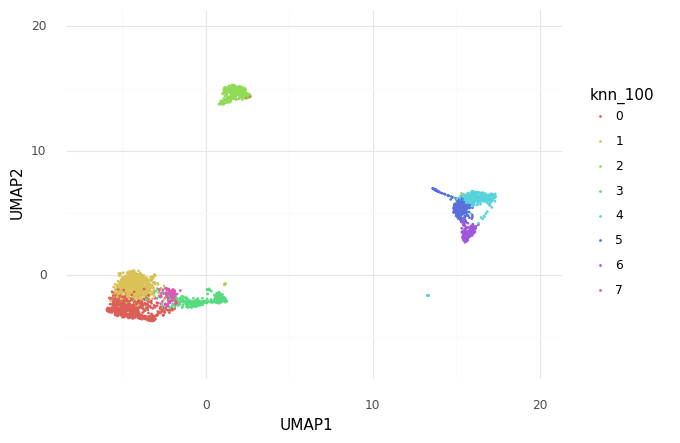

<ggplot: (2932196404306)>

In [127]:
(
    pn.ggplot(embedding_labels) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'knn_100'), size = .1) + 
    pn.xlim([-7, 20]) + 
    pn.ylim([-7, 20]) + 
    pn.theme_minimal()
)

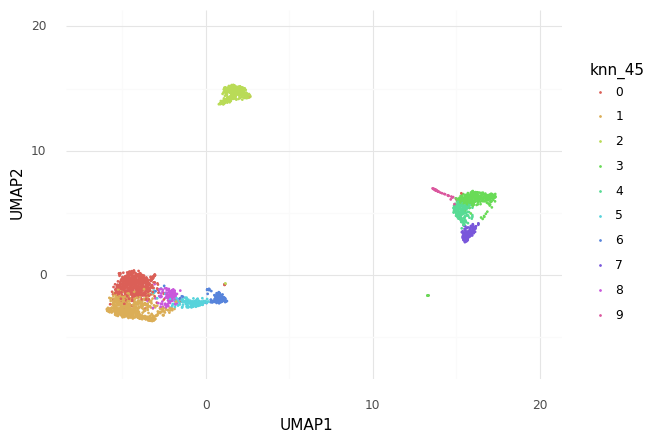

<ggplot: (2932184234924)>

In [128]:
(
    pn.ggplot(embedding_labels) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'knn_45'), size = .1) + 
    pn.xlim([-7, 20]) + 
    pn.ylim([-7, 20]) + 
    pn.theme_minimal()
)

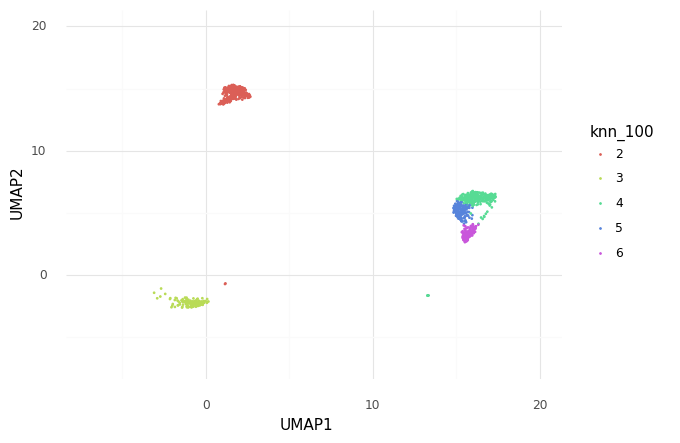

<ggplot: (2932184126254)>

In [129]:
(
    pn.ggplot(embedding_labels[embedding_labels.Barcode.isin(res)]) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'knn_100'), size = .1) + 
    pn.xlim([-7, 20]) + 
    pn.ylim([-7, 20]) + 
    pn.theme_minimal()
)

In [140]:
nc = all_permute_metrics[all_permute_metrics['nCluPass_both']].query('knn == @t_k')['cluster_ids'].to_numpy()
strat_2_labels = all_labels[(all_labels[minor_k].isin(nc))]['Barcode'].to_numpy()

In [133]:
all_permute_metrics[all_permute_metrics['nCluPass_both']].query('knn == @t_k')

,cluster_ids,permute_stability,permute_purity,exp_name,knn,nCluPass_stability,nCluPass_purity,nCluPass_both
8,3,0.948269,0.943238,experiment2-pbmc-45-louvainPrune,45,True,True,True
7,2,0.982330,0.957100,experiment2-pbmc-45-louvainPrune,45,True,True,True
6,6,0.983907,0.922660,experiment2-pbmc-45-louvainPrune,45,True,True,True
4,7,0.992917,0.934895,experiment2-pbmc-45-louvainPrune,45,True,True,True
3,5,0.823219,0.919311,experiment2-pbmc-45-louvainPrune,45,True,True,True


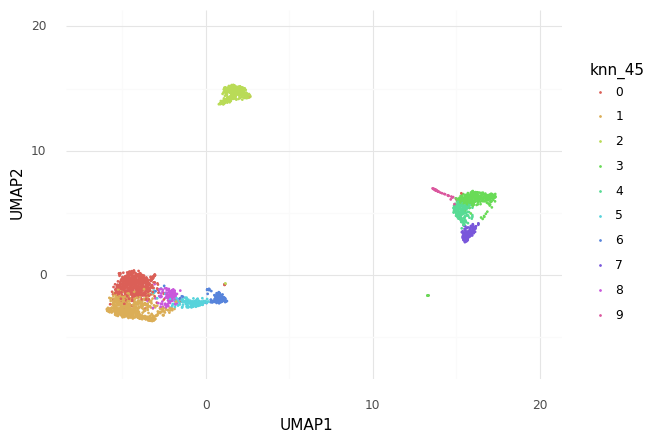

<ggplot: (2932196634844)>

In [141]:
(
    pn.ggplot(embedding_labels) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'knn_45'), size = .1) + 
    pn.xlim([-7, 20]) + 
    pn.ylim([-7, 20]) + 
    pn.theme_minimal()
)

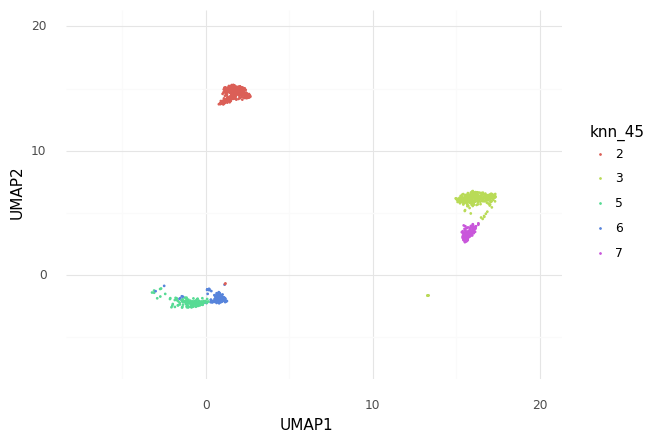

<ggplot: (2932184034952)>

In [149]:
(
    pn.ggplot(embedding_labels[embedding_labels.Barcode.isin(strat_2_labels)]) + 
    pn.geom_point(pn.aes(x='UMAP1', y='UMAP2', color = 'knn_45'), size = .1) + 
    pn.xlim([-7, 20]) + 
    pn.ylim([-7, 20]) + 
    pn.theme_minimal()
)

In [145]:
len(set(res).intersection(set(strat_2_labels)))

948

In [146]:
len(res)

1117

In [147]:
len(strat_2_labels)

1141